In [1]:
import polars as pl
import pandas as pd
import numpy as np
import time
import re, os
import random
import optuna
from tqdm import tqdm
import lightgbm
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
from m4_feats_polars import *
from m5_sb_models import *
warnings.filterwarnings("ignore")

## Feature Selection: Null Importances

In [2]:
def get_feature_importances(data_x, data_y, valid_x, valid_y, model_params, shuffle, seed=None):
    if seed == None:
        model_params['random_state'] = None

    gain_model = LGBMRegressor(importance_type='gain', **model_params)
    split_model = LGBMRegressor(importance_type='split', **model_params)

    if shuffle:
        random.shuffle(data_y)
        random.shuffle(valid_y)
        
    gain_model.fit(data_x, data_y, eval_set=[(valid_x, valid_y)])
    split_model.fit(data_x, data_y, eval_set=[(valid_x, valid_y)])

    imp_df = pd.DataFrame()
    imp_df["feature"] = list(data_x)
    imp_df["importance_gain"] = gain_model.feature_importances_
    imp_df["importance_split"] = split_model.feature_importances_    
    return imp_df


def get_batch_imp_df(data_x, data_y, valid_x, valid_y, model_params, nb_runs=10, null_flag=True):
    batch_imp_df = pd.DataFrame()
    print(f'Run {nb_runs} rounds of model training:')
    for i in tqdm(range(nb_runs)):
        if null_flag:
            imp_df = get_feature_importances(data_x, data_y, valid_x, valid_y, model_params, shuffle=True, seed=None)
        else:
            imp_df = get_feature_importances(data_x, data_y, valid_x, valid_y, model_params, shuffle=False, seed=None)
        imp_df['run'] = i + 1 
        batch_imp_df = pd.concat([batch_imp_df, imp_df], axis=0)
    return batch_imp_df


def display_distributions(actual_imp_df_, null_imp_df_, feature_):
    plt.figure(figsize=(13, 6))
    gs = gridspec.GridSpec(1, 2)
    # Plot Split importances
    ax = plt.subplot(gs[0, 0])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_split'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_split'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Split Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (split) Distribution for %s ' % feature_.upper())
    # Plot Gain importances
    ax = plt.subplot(gs[0, 1])
    a = ax.hist(null_imp_df_.loc[null_imp_df_['feature'] == feature_, 'importance_gain'].values, label='Null importances')
    ax.vlines(x=actual_imp_df_.loc[actual_imp_df_['feature'] == feature_, 'importance_gain'].mean(), 
               ymin=0, ymax=np.max(a[0]), color='r',linewidth=10, label='Real Target')
    ax.legend()
    ax.set_title('Gain Importance of %s' % feature_.upper(), fontweight='bold')
    plt.xlabel('Null Importance (gain) Distribution for %s ' % feature_.upper())

    
def normalize_feat_imp(imp_df):
    avg_gain_imp_df = imp_df.groupby(by=['feature'])['importance_gain'].mean().reset_index()
    avg_split_imp_df = imp_df.groupby(by=['feature'])['importance_split'].mean().reset_index()
    # rank-normalize score
    avg_gain_imp_df['importance_gain'] = avg_gain_imp_df['importance_gain'].rank(ascending=False, pct=True)
    avg_split_imp_df['importance_split'] = avg_split_imp_df['importance_split'].rank(ascending=False, pct=True)
    avg_imp_df = pd.merge(avg_gain_imp_df, avg_split_imp_df, on='feature')
    # # normalize score
    # avg_imp_df['importance_gain'] = (avg_imp_df['importance_gain'] - avg_imp_df['importance_gain'].min())  / (avg_imp_df['importance_gain'].max() - avg_imp_df['importance_gain'].min())
    # avg_imp_df['importance_split'] = (avg_imp_df['importance_split'] - avg_imp_df['importance_split'].min())  / (avg_imp_df['importance_split'].max() - avg_imp_df['importance_split'].min())
    return avg_imp_df


def nul_imp_feat_select(model_params,
                        train_x, train_y, valid_x, valid_y,
                        actual_avg_imp_df, null_avg_imp_df,
                        search_thres=[ 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 1],
                        search_criterion=['gain', 'split', 'both']):
    feat_select_dfs = []
    for search_cri in search_criterion:
        print(f'Feature Selection by Null Importances: {search_cri}:')
        for threshold in tqdm(search_thres):
            if 'split' == search_cri:
                actual_feats = actual_avg_imp_df[actual_avg_imp_df['importance_split']>threshold]['feature'].values.tolist()
                null_feats = null_avg_imp_df[null_avg_imp_df['importance_split']>threshold]['feature'].values.tolist()
                unstable_feats = set(actual_feats + null_feats)
                feats = [_f for _f in actual_avg_imp_df['feature'].unique() if _f not in unstable_feats]
            elif 'gain' == search_cri:
                actual_feats = actual_avg_imp_df[actual_avg_imp_df['importance_gain']>threshold]['feature'].values.tolist()
                null_feats = null_avg_imp_df[null_avg_imp_df['importance_gain']>threshold]['feature'].values.tolist()
                unstable_feats = set(actual_feats + null_feats)
                feats = [_f for _f in actual_avg_imp_df['feature'].unique() if _f not in unstable_feats]
            elif 'both' == search_cri:
                actual_feats = actual_avg_imp_df[actual_avg_imp_df['importance_split']>threshold]['feature'].values.tolist()
                null_feats = null_avg_imp_df[null_avg_imp_df['importance_split']>threshold]['feature'].values.tolist()
                unstable_feats1 = set(actual_feats + null_feats)

                actual_feats = actual_avg_imp_df[actual_avg_imp_df['importance_gain']>threshold]['feature'].values.tolist()
                null_feats = null_avg_imp_df[null_avg_imp_df['importance_gain']>threshold]['feature'].values.tolist()
                unstable_feats2 = set(actual_feats + null_feats)
                
                unstable_feats = set(list(unstable_feats1) + list(unstable_feats2))
                feats = [_f for _f in actual_avg_imp_df['feature'].unique() if _f not in unstable_feats]

            model = LGBMRegressor(**model_params)
            model.fit(train_x[feats], train_y, eval_set=[(valid_x[feats], valid_y)])
            valid_pred_y = model.predict(valid_x[feats], num_iteration=model.best_iteration_)  
            valid_eval_rmse = mean_squared_error(valid_y, valid_pred_y, squared=False) 
            feat_select_dfs.append([search_cri, threshold, feats, len(feats), valid_eval_rmse])
    feat_select_dfs = pd.DataFrame(feat_select_dfs)   
    feat_select_dfs.columns = ['imp_type', 'threshold', 'features', 'feature_number', 'valid_eval_rmse']    
    return feat_select_dfs

## Data Loading

In [3]:
# [('train_down_events_counts.pkl', 26),
#  ('train_vector_one_gram.pkl', 26),
#  ('train_create_pauses.pkl', 26),
#  ('train_essay_paragraphs.pkl', 26),
#  ('train_cursor_pos_acceleration.pkl', 11),
#  ('train_word_count_acceleration.pkl', 6),
#  ('train_p_burst_feats.pkl', 5),
#  ('train_r_burst_feats.pkl', 3),
#  ('train_events_counts_acceleration.pkl', 3),
#  ('train_essay_sentences.pkl', 3),
#  ('train_categorical_nunique.pkl', 3),
#  ('train_vector_two_gram.pkl', 2),
#  ('train_cursor_pos_rate_of_change.pkl', 2),
#  ('train_word_counts_rate_of_change.pkl', 2),
#  ('train_count_of_activities.pkl', 2),
#  ('train_action_time_by_activity.pkl', 1),
#  ('train_product_to_keys.pkl', 1),
#  ('train_IKI_based_fractals.pkl', 1),
#  ('train_events_counts_baseline.pkl', 1)]

In [4]:
data_path     = 'kaggle/input/linking-writing-processes-to-writing-quality/'
train_logs    = pl.scan_csv(f'{data_path}/train_logs.csv')
test_logs    = pl.scan_csv(f'{data_path}/test_logs.csv')
train_scores = pl.scan_csv(f'{data_path}/train_scores.csv')

train_essays          = get_essay_df(train_logs.collect().to_pandas())
test_essays           = get_essay_df(test_logs.collect().to_pandas())

tr_down_events_counts, ts_down_events_counts = down_events_counts(train_logs, test_logs)
tr_vect_one, ts_vect_one = countvectorize_one_one(train_essays, test_essays)
tr_pauses, ts_pauses = create_pauses(train_logs, test_logs)
tr_cursor_pos_acc, ts_cursor_pos_acc = cursor_pos_acceleration(train_logs, test_logs)
tr_cursor_pos_roc, ts_cursor_pos_roc = cursor_pos_rate_of_change(train_logs, test_logs)

tr_word_count_acc, ts_word_count_acc = word_count_acceleration(train_logs, test_logs)
tr_event_acc, ts_event_acc = events_counts_acceleration(train_logs, test_logs)
tr_vect_two, ts_vect_two = countvectorize_two_one(train_essays, test_essays)
tr_time_by_act, ts_time_by_act = action_time_by_activity(train_logs, test_logs)

tr_act_count, ts_act_count = count_of_activities(train_logs, test_logs)
tr_r_burst, ts_r_burst = r_burst_feats(train_logs, test_logs)
tr_p_burst, ts_p_burst = p_burst_feats(train_logs, test_logs, 2)
tr_nunique, ts_nunique = categorical_nunique(train_logs, test_logs)
tr_get_keys, ts_get_keys = get_keys_pressed_per_second(train_logs.collect().to_pandas(), 
                                                       test_logs.collect().to_pandas())

tr_input_change, ts_input_change = input_text_change_feats(train_logs, test_logs)
tr_wc_roc, ts_wc_roc =  word_counts_rate_of_change(train_logs, test_logs)


train_feats = tr_down_events_counts.join(tr_vect_one, on='id', how='left')
train_feats = train_feats.join(tr_pauses, on='id', how='left')
# train_feats = train_feats.join(tr_cursor_pos_acc, on='id', how='left')
# train_feats = train_feats.join(tr_word_count_acc, on='id', how='left')
# train_feats = train_feats.join(tr_p_burst, on='id', how='left')
# train_feats = train_feats.join(tr_r_burst, on='id', how='left')
# train_feats = train_feats.join(tr_event_acc, on='id', how='left')
# train_feats = train_feats.join(tr_nunique, on='id', how='left')
# train_feats = train_feats.join(tr_vect_two, on='id', how='left')
# train_feats = train_feats.join(tr_wc_roc, on='id', how='left')
# train_feats = train_feats.join(tr_act_count, on='id', how='left')
# train_feats = train_feats.join(tr_cursor_pos_roc, on='id', how='left')
# train_feats = train_feats.join(tr_get_keys, on='id', how='left')
# train_feats = train_feats.join(tr_input_change, on='id', how='left')
# train_feats = train_feats.join(tr_time_by_act, on='id', how='left')

test_feats = ts_down_events_counts.join(ts_vect_one, on='id', how='left')
test_feats = test_feats.join(ts_pauses, on='id', how='left')
test_feats = test_feats.join(ts_cursor_pos_acc, on='id', how='left')
test_feats = test_feats.join(ts_word_count_acc, on='id', how='left')
test_feats = test_feats.join(ts_r_burst, on='id', how='left')
test_feats = test_feats.join(ts_p_burst, on='id', how='left')
test_feats = test_feats.join(tr_event_acc, on='id', how='left')
test_feats = test_feats.join(ts_nunique, on='id', how='left')
test_feats = test_feats.join(ts_vect_two, on='id', how='left')
test_feats = test_feats.join(ts_wc_roc, on='id', how='left')
test_feats = test_feats.join(ts_act_count, on='id', how='left')
test_feats = test_feats.join(ts_cursor_pos_roc, on='id', how='left')


# test_feats = test_feats.join(ts_get_keys, on='id', how='left')
# test_feats = test_feats.join(ts_input_change, on='id', how='left')
# test_feats = test_feats.join(ts_time_by_act, on='id', how='left')


train_logs = train_logs.collect().to_pandas()
test_logs = test_logs.collect().to_pandas()
train_scores = train_scores.collect().to_pandas()
train_feats = train_feats.sort('id')
train_feats = train_feats.collect().to_pandas()
test_feats = test_feats.collect().to_pandas()

train_feats           = train_feats.merge(parag_feats(train_essays), on='id', how='left')
test_feats            = test_feats.merge(parag_feats(test_essays), on='id', how='left')

train_feats           = train_feats.merge(sent_feats(train_essays), on='id', how='left')
test_feats            = test_feats.merge(sent_feats(test_essays), on='id', how='left')

< Events counts features >
< Count vectorize one-grams >
< Idle time features >
< cursor position acceleration >
< event_id rate of change >
< word count acceleration >
< events counts acceleration >
< Count vectorize bi-grams >
< Action time by activities >
< R-burst features >
< P-burst features >
< Categorical # unique values features >
< Input text change features >
< Word counts rate of change features >
< Essays paragraphs feats >
< Essays paragraphs feats >
< Essays sentences feats >
< Essays sentences feats >


In [5]:
print('< Mapping >')
# train_scores   = pd.read_csv(data_path + 'train_scores.csv')
data           = train_feats.merge(train_scores, on='id', how='left')
x              = data.drop(['id', 'score'], axis=1)
y              = data['score'].values
print(f'Number of features: {len(x.columns)}')

## Model Training

In [6]:
param = {
        'n_estimators': 1024,
         'learning_rate': 0.005,
         'metric': 'rmse',
         'random_state': 42,
         'force_col_wise': True,
         'verbosity': -1,
         'early_stopping_round': 100
        }


data_x = x.copy()
data_y = y.copy()
model_params = param
random_state = 42
n_splits = 5
nb_runs = 50
train_feat_select = True

skf    = StratifiedKFold(n_splits=n_splits, random_state=random_state, shuffle=True)
test_y = np.zeros(len(data_x))

for i, (train_index, valid_index) in enumerate(skf.split(data_x, data_y.astype(str))):
    print(f'Fold:{i}:')
    train_x, train_y, valid_x, valid_y = train_valid_split(data_x, data_y, train_index, valid_index)

    if train_feat_select:
        print('Feature Selection (get null_imp_df):')
        null_imp_df = get_batch_imp_df(data_x.copy(), data_y.copy(), valid_x.copy(), valid_y.copy(), model_params, nb_runs=nb_runs, null_flag=True)
        print('Feature Selection (actual_imp_df):')
        actual_imp_df = get_batch_imp_df(data_x.copy(), data_y.copy(), valid_x.copy(), valid_y.copy(), model_params, nb_runs=nb_runs, null_flag=False)

        actual_avg_imp_df = normalize_feat_imp(actual_imp_df)
        null_avg_imp_df = normalize_feat_imp(null_imp_df)
        feat_select_dfs = nul_imp_feat_select(model_params,
                            train_x, train_y, valid_x, valid_y,
                            actual_avg_imp_df, null_avg_imp_df,
                            search_thres=[0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 1],
                            search_criterion=['gain', 'split', 'both'])
        
        if not os.path.exists('feature_selection/'):
            os.mkdir('feature_selection/')
        feat_select_dfs.to_csv(f'feature_selection/feature_selection_res_fold{i}.csv', index=False)
        valid_min_eval_rmse = feat_select_dfs['valid_eval_rmse'].min()
        optimal_feat_select_res = feat_select_dfs[feat_select_dfs['valid_eval_rmse'] == valid_min_eval_rmse].values[0]
        np.save(f'feature_selection/optimal_feat_select_res_fold{i}.npy', optimal_feat_select_res)

    use_feats = np.load(f'feature_selection/optimal_feat_select_res_fold{i}.npy', allow_pickle=True)
    print(f'After feature selection: {len(list(train_x))} -> {len(use_feats[2])}.')
    train_x = train_x[use_feats[2]]
    valid_x = valid_x[use_feats[2]]

    model = LGBMRegressor(**model_params)
    model.fit(train_x, train_y, 
            #   eval_set=[(train_x, train_y), (valid_x, valid_y)],
                eval_set=[(valid_x, valid_y)],
                )
    test_y[valid_index] = model.predict(valid_x, num_iteration=model.best_iteration_)

    model.booster_.save_model(f'results/model_fold{i}.txt', num_iteration=model.best_iteration_)


    importances = model.feature_importances_
    feature_list = list(train_x)
    feature_imp = pd.DataFrame({'feature':feature_list, 'importance':importances})
    feature_imp['importance'] = (feature_imp['importance'] - feature_imp['importance'].min())  / (feature_imp['importance'].max() - feature_imp['importance'].min())
    feature_imp = feature_imp.sort_values(by='importance', ascending=False)
    feature_imp.to_csv(f'results/model_feat_imp_fold{i}.csv', index=False)
    print('-'*20)
    del model

eval_rmse = mean_squared_error(data_y, test_y, squared=False)
print('Eval RMSE:', eval_rmse)

NameError: name 'x' is not defined

In [ ]:
import pandas as pd
import os

# Folder containing the CSV files
folder_path = 'results'

# List to hold each DataFrame
dataframes = []

# Read each CSV file into a DataFrame and append it to the list
for file in os.listdir(folder_path):
    if file.endswith('.csv'):
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path)
        dataframes.append(df)

# Combine all DataFrames into a single DataFrame
combined_df = pd.concat(dataframes)

# Group by the 'feature' column and calculate the mean of the 'importance' column
average_importance = combined_df.groupby('feature')['importance'].mean().reset_index()

# Display the result
print(average_importance)

                 feature  importance
0         activity_0_cnt    0.104651
1         activity_2_cnt    0.166154
2           bigram_tok_0    0.054663
3           bigram_tok_1    0.135727
4           bigram_tok_2    0.109668
..                   ...         ...
144   word_count_acc_neg    0.080117
145   word_count_acc_pst    0.092094
146  word_count_acc_skew    0.366315
147   word_count_acc_std    0.134593
148  word_count_acc_zero    0.047430

[149 rows x 2 columns]


In [ ]:
feat_selection = list(average_importance['feature'])

In [ ]:
feat_selection

['one_gram_tok_9',
 'sent_len_sum',
 'down_event_6',
 'one_gram_tok_5',
 'one_gram_tok_8',
 'pauses_1_sec',
 'down_event_12',
 'down_event_13',
 'one_gram_tok_7',
 'sent_len_median',
 'word_count_acc_skew',
 'one_gram_tok_6',
 'inter_key_median_lantency',
 'down_event_1',
 'evid_acc_skew',
 'paragraph_word_count_max',
 'down_event_11',
 'paragraph_len_median',
 'pauses_1_half_sec',
 'cursor_pos_acc_max',
 'cursor_pos_acc_skew',
 'evid_acc_std',
 'bigram_tok_5',
 'roc_std',
 'inter_key_largest_lantency',
 'paragraph_word_count_last',
 'bigram_tok_7',
 'paragraph_len_sum',
 'sent_len_q1',
 'one_gram_tok_4',
 'sent_word_count_max',
 'down_event_3',
 'evid_acc_kurt',
 'pauses_half_sec',
 'paragraph_word_count_first',
 'pos_change_count',
 'paragraph_len_q1',
 'r_burst_std',
 'text_change_nunique',
 'one_gram_tok_0',
 'paragraph_len_min',
 'r_burst_count',
 'sent_len_last',
 'sent_len_first',
 'cursor_pos_roc_kurt',
 'down_event_2',
 'paragraph_word_count_median',
 'one_gram_tok_2',
 'r_bur

In [ ]:
for index, row in average_importance.iterrows():
    print(row['feature'], row['importance'])

one_gram_tok_9 0.9514864624298036
sent_len_sum 0.9241126070991431
down_event_6 0.764242487581747
one_gram_tok_5 0.6353704396323844
one_gram_tok_8 0.58542807050544
pauses_1_sec 0.5561347550506213
down_event_12 0.4852005659766802
down_event_13 0.4352507071942715
one_gram_tok_7 0.40854623909189397
sent_len_median 0.3988455342666729
word_count_acc_skew 0.3663151565646689
one_gram_tok_6 0.35105555151949297
inter_key_median_lantency 0.35078366995698895
down_event_1 0.34749866250865763
evid_acc_skew 0.3381663963079646
paragraph_word_count_max 0.3353319957529689
down_event_11 0.3200860266465119
paragraph_len_median 0.31771634120046116
pauses_1_half_sec 0.3085920800152099
cursor_pos_acc_max 0.30304092103268165
cursor_pos_acc_skew 0.3001939233904056
evid_acc_std 0.2917204974243418
bigram_tok_5 0.2854478551416345
roc_std 0.28543045324857336
inter_key_largest_lantency 0.28431732815600735
paragraph_word_count_last 0.28205933456374427
bigram_tok_7 0.27819140299160516
paragraph_len_sum 0.278083775329

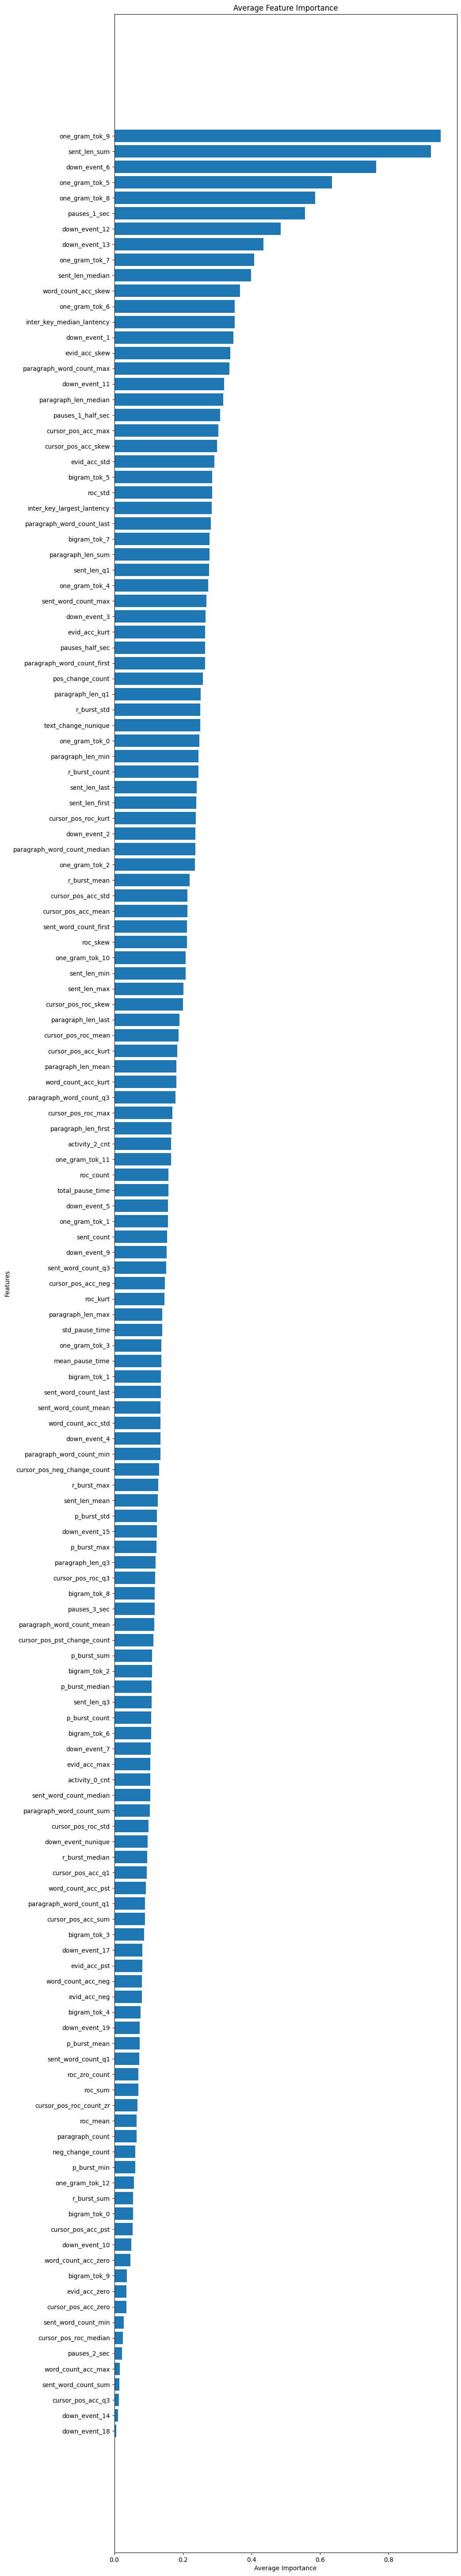

In [ ]:
average_importance = average_importance.sort_values('importance', ascending=False)
plt.figure(figsize=(10, 0.5 * len(average_importance)))  # Height is 0.5 times the number of features

# Create a horizontal bar plot
plt.barh(average_importance['feature'], average_importance['importance'])
plt.xlabel('Average Importance')
plt.ylabel('Features')
plt.title('Average Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis for better readability

# Show the plot
plt.show()


In [ ]:
average_importance

,feature,importance
64,one_gram_tok_9,0.952143
112,sent_len_sum,0.927458
26,down_event_3,0.740399
60,one_gram_tok_5,0.642806
92,pauses_1_sec,0.640254
...,...,...
56,one_gram_tok_15,0.000000
100,r_burst_min,0.000000
4,cursor_pos_acc_median,0.000000
135,word_count_acc_sum,0.000000


## Test Inference

In [ ]:
data_path     = '/kaggle/input/linking-writing-processes-to-writing-quality/'

print('< Testing Data >')
test_logs   = pl.scan_csv(data_path + 'test_logs.csv')
test_feats  = dev_feats(test_logs)
test_feats  = test_feats.collect().to_pandas()

test_logs             = test_logs.collect().to_pandas()
test_essays           = get_essay_df(test_logs)
test_feats            = test_feats.merge(word_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(sent_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(parag_feats(test_essays), on='id', how='left')
test_feats            = test_feats.merge(get_keys_pressed_per_second(test_logs), on='id', how='left')
test_feats            = test_feats.merge(product_to_keys(test_logs, test_essays), on='id', how='left')


test_ids = test_feats['id'].values
testin_x = test_feats.drop(['id'], axis=1)

print('< Learning and Evaluation >')
param = {
        'n_estimators': 1024,
         'learning_rate': 0.005,
         'metric': 'rmse',
         'random_state': 42,
         'force_col_wise': True,
         'verbosity': 1,
         'early_stopping_round': 100
        }


solution = LGBMRegressor(**param)
test_y_pred = inference(test_x=testin_x.copy())
sub = pd.DataFrame({'id': test_ids, 'score': test_y_pred})
sub.to_csv('submission.csv', index=False)

< Testing Data >
< Count by values features >
< Input words stats features >
< Numerical columns features >
< Categorical columns features >
< Idle time features >
< P-bursts features >
< R-bursts features >
< Learning and Evaluation >


In [ ]:
!rm -rf /kaggle/working/results
!rm -rf /kaggle/working/feature_selection